# Computational Methods for Astrophysics, Homework #5, Askold Vilkha, Taylor Paul, Clive Binu

In [2]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
from sympy import *
import chebyshev as cheby
from scipy import linalg

## Exercise 1, Solving Boundary Value Problem using Chebyshev polynomials

For this exercise, we will solve the following Boundary Value Problem (BVP)

\begin{split}
  y''(r) + \frac{2}{r} y'(r) = - 4\pi \rho, \quad 0 < r < r_{\rm out},\\
  y'(0) = 0,\\
  r_{\rm out} y'(r_{\rm out}) + y(r_{\rm out}) = 0
\end{split} 

 
Here, we will use Chebyshev polynomials to approximate $y$.
$$ y(r) \approx \sum_{n=0}^{n_{\rm max}} c_n T_n(x(r)), $$
where 
$$x(r) = -1 + 2\left(  \frac{r-0}{r_{\rm max} - 0}\right)  $$
Therefore:
$$
x(0) = -1, \quad x(r_{\rm out}) = 1$$
Hence:
$$dx/dr = 2 / r_{\rm max}$$
 
We'll solve the above equations for Chebyshev coefficients $c_n$ on Gauss-Lobatto grid with $n_{\rm max} + 1$ points, the first and the last of these being the two end points of the domain.

$$ y'(0) = 0 \to  \sum_{n=0}^{n_{\rm max}} c_n T'_n(-1) dx/dr = 0,$$ 

$$ r_{\rm out} y'(r_{\rm out}) + y(r_{\rm out}) = 0  \to 
\sum_{n=0}^{n_{\rm max}} c_n \left[r_{\rm out} T'_n(1) dx/dr + T_n(1)\right] = 0$$ 


$$ \sum_{n=0}^{n_{\rm max}} c_n(T''(x_i) (dx/dr)^2 + \frac{2}{r_i} (dx/dr) T'(x_i) ) = - 4 \pi \rho(r_i), \quad i= 1\cdots n_{\rm max} - 1
$$

All of these are equivalent to matrix equations of the form
$$
{\bf J}{\bf C} = {\bf S},
$$
where ${\bf C} = (c_0, c_1, \cdots)^T$, and this matrix represents the Chebyshev coefficients. Matrix ${\bf J}$ is the Jacobian matrix, and ${\bf S}$ is the source term, or RHS of the equations above.
Hence ${\bf C} = {\bf J}^{-1} {\bf S}$. 

In [3]:
def SolveLinAlg(A, B):
    """
    Solve the Matric problem Ax = B for x via LU decomposition
    """
    LU, P = linalg.lu_factor(A)
    return linalg.lu_solve((LU, P), B)

# Askold: can this be replaced by linalg.solve(A, B)?
# Yes it can and will be replaced in the next commit!

In [180]:
def rho_func(r: np.ndarray, r_in: float = 0, r_out: float = 10):
    '''
    Function to calculate the density function rho(r) for a given r

    Parameters
    ----------
    r : np.ndarray
        Array of r values
    r_in : float, optional
        Inner radius, by default 0
    r_out : float, optional
        Outer radius, by default 10
    
    Returns
    -------
    rho_val : np.ndarray
        Array of rho values
    
    Raises
    ------
    ValueError
        If r contains negative values
    '''

    if np.min(r) < r_in or np.max(r) > r_out:
        raise ValueError('r must be in the interval [r_in, r_out]')

    rho_val = np.where(r <= 1, 1, np.exp(-r + 1))

    return rho_val

In [49]:
def x_and_r_func(r: float = None, x: float = None, r_in: float = 0, r_out: float = 10):
    '''
    Function to calculate the x(r) or r(x), and dx/dr for a given r or x. Either r or x must be specified. If r is provided, x is calculated, and vice versa.

    Parameters
    ----------
    r : float, optional
        Radius, by default None
    x : float, optional
        x, by default None
    r_in : float, optional
        Inner radius, by default 0
    r_out : float, optional
        Outer radius, by default 10
    
    Returns
    -------
    x_of_r : float
        x value for a given r
    r_of_x : float
        r value for a given x
    dx_over_dr : float
        dx/dr for a given r
    
    Raises
    ------
    ValueError
        If r is not between r_in and r_out
    ValueError
        If both r and x are specified or None of them are specified

    '''

    if np.all(r) != None:
        if np.any(r < r_in) or np.any(r > r_out):
            raise ValueError('r must be between r_in and r_out')
    
    if (r is None) == (x is None):
        raise ValueError('Either r or x must be specified')
    
    dx_over_dr = 2 / (r_out - r_in)

    if r is None:
        r_of_x = r_in + (r_out - r_in) * (x + 1) / 2
        return r_of_x, dx_over_dr
    else:
        x_of_r = -1 + 2 * (r - r_in) / (r_out - r_in)
        return x_of_r, dx_over_dr

In [192]:
Nmax = 500
r_in = 0; r_out = 10
x_grid = cheby.GaussLobattoGrid(Nmax)
r_grid, dxdr = x_and_r_func(x = x_grid, r_in = r_in, r_out = r_out)
J_matr = np.zeros((Nmax + 1, Nmax + 1))


# first  and last rows
# Note the n of Tn is equal to the column number
for col in range(Nmax + 1):
    # r=0 boundary condition
    J_matr[0, col] = dxdr * cheby.ChebyshevTx(col, -1)

    # outer BC
    J_matr[-1, col] = r_out * dxdr * cheby.ChebyshevTx(col, 1) + cheby.ChebyshevT(col, 1)

S_matr = -4 * np.pi * rho_func(r_grid,  r_in = r_in, r_out = r_out)  # source term for 'most' of the grid

S_matr[0] = 0  # source terms on the boundaries
S_matr[-1] = 0

# Enforcing solution in the interior points.
for row in range(1, Nmax):
    for col in range(Nmax + 1):
        J_matr[row, col] = (np.power(dxdr, 2) * cheby.ChebyshevTxx(col, x_grid[row])+ 2.0 / r_grid[row] * dxdr * cheby.ChebyshevTx(col, x_grid[row]))

In [193]:
# solve the matrix equation and get the Chebyshev coefficients
C_matr = linalg.solve(J_matr, S_matr)

In [194]:
# reconstruct solution on a fine grid
test_grid = np.linspace(r_in + 1.0e-4, r_out - 1.0e-4, 500)
x_grid = x_and_r_func(r = test_grid, r_in = r_in, r_out = r_out)[0]

solution = [cheby.ReconT(C_matr, x) for x in x_grid]
# y_p - first derivative, y_pp - second derivative
y_p = np.array([cheby.ReconTx(C_matr, x) for x in x_grid]) * dxdr
y_pp = np.array([cheby.ReconTxx(C_matr, x) for x in x_grid]) * np.power(dxdr, 2)

resid = y_pp + 2 / test_grid * y_p + 4 * np.pi * rho_func(test_grid, r_in = r_in, r_out = r_out)

The resulting numerical solution is shown in Fig. 1.

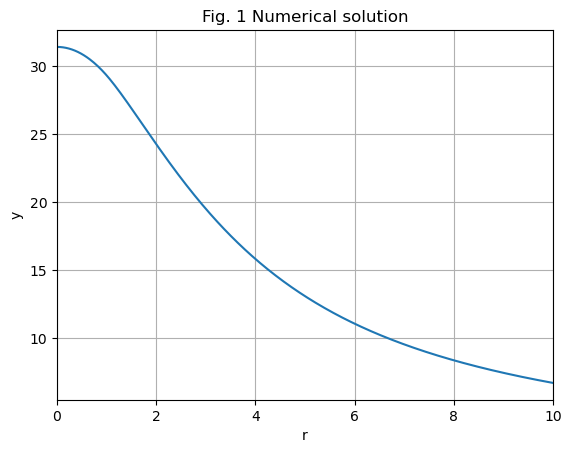

In [311]:
plt.plot(test_grid, solution)
plt.xlabel('r')
plt.ylabel('y')
plt.xlim(0, 10); plt.grid(True)
plt.title('Fig. 1 Numerical solution');

Now that we have solved the problem numerically, we can compare the numerical solution with the analytical solution. To obtain the analytical solution, we use the computer algebra package `sympy`. Note, that for the equation that we have, we need to use some "trickery". First of all, we are going to solve two differential equations, corresponding to the two subdomains, since they have different values of $\rho$ function.

In [221]:
# define the symbols
r_sym = Symbol('r')
y_sym = Function('y')
rho_func_sym = Function('rho')

# define the differential equation
eq = Eq(y_sym(r_sym).diff(r_sym).diff(r_sym) + 2 / r_sym * y_sym(r_sym).diff(r_sym) + 4 * pi * rho_func_sym(r_sym), 0)

# substitute rho with its definition
eq_1 = eq.subs(rho_func_sym(r_sym), 1) # the rho function at 0 < r < 1 
eq_2 = eq.subs(rho_func_sym(r_sym), exp(-r_sym + 1)) # the rho function at 1 < r < 10 

# define the boundary conditions
ics_1_sym = {y_sym(r_sym).diff(r_sym).subs(r_sym, 0): 0}

# solve the differential equation
sol_1 = dsolve(eq_1, ics = ics_1_sym)
sol_2 = dsolve(eq_2)

In [285]:
sol_1.rhs # solution for rho = 1

C1 - 2*pi*r**2/3

In [286]:
sol_2.rhs #solution for rho = exp(-r + 1)

C1 + C2/r - 4*pi*exp(1 - r) - 8*pi*exp(1 - r)/r

As we can see, these solution still have some unknown constants. That happens because our first initial condition ($y'(0) = 0$) can only be applied to the subdomain $r \in [0, 1]$, where $\rho(r) = 1$. Another initial condition ($r_{\rm max} y'(r_{\rm max}) + y(r_{\rm max}) = 0$) can only be applied to the subdomain $r \in [1, r_{\rm max}]$, where $\rho(r) = e^{-r + 1}$. We can use it to obtain constant $C_1$ for the `sol_2`. This is shown below.

In [225]:
(sol_2.rhs.diff(r_sym) * r_sym).subs(r_sym, 10) + sol_2.rhs.subs(r_sym, 10)

C1 + 44*pi*exp(-9)

Therefore, $C_1 = \frac{ - 44 \pi}{e^9}$ (for the 2nd solution). Now we can apply continuity condition to find $C_1$ for the first solution and $C_2$ for the second solution. This is shown below.

In [304]:
C1 = Symbol('C1')
C2 = Symbol('C2')
sol_2.rhs.subs({r_sym: 1, C1: - 44 * np.pi / np.power(np.e, 9)})  - sol_1.rhs.subs(r_sym, 1)

-C1 + C2 - 34*pi/3 - 0.0170589466915854

This has to be zero, thus we know the difference between $C_1$ (`sol_1`) and $C_2$ (`sol_2`). Even though we do not know specific value of $C_1$ and $C_2$, we can still try to choose them assuming that the function is continuous and does not have a peak at $r = 1$. This is shown below in Fig. 2. We have chosen $C_1 = 10 \pi$

In [307]:
sol_1_func = lambdify(r_sym, sol_1.rhs.subs(C1, 10 * np.pi))
sol_2_func = lambdify(r_sym, sol_2.rhs.subs({C1: - 44 * np.pi / np.power(np.e, 9), C2: 10 * np.pi + 34 /3 * np.pi + 44 * np.pi / np.power(np.e, 9)}))

In [313]:
def analytic_func(r: np.ndarray, r_in: float = 0, r_out: float = 10):
    '''
    Function to calculate the analytic solution for a given r

    Parameters
    ----------
    r : np.ndarray
        Array of r values
    r_in : float, optional
        Inner radius, by default 0
    r_out : float, optional
        Outer radius, by default 10
    
    Returns
    -------
    analytic_sol : np.ndarray
        Array of analytic solution values
    
    Raises
    ------
    ValueError
        If r contains negative values
    '''

    if np.min(r) < r_in or np.max(r) > r_out:
        raise ValueError('r must be in the interval [r_in, r_out]')

    analytic_sol = np.where(r <= 1, sol_1_func(r), sol_2_func(r))

    return analytic_sol

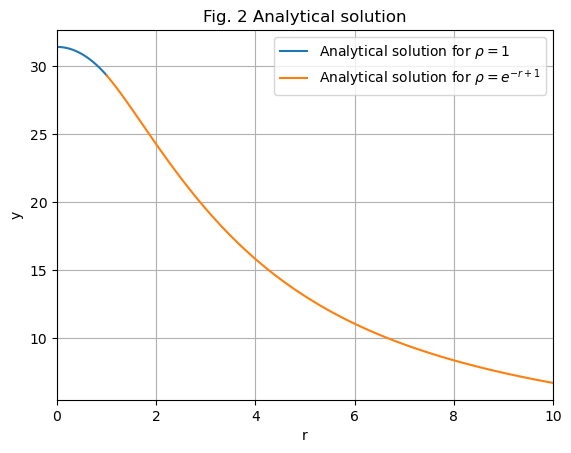

In [314]:
r_test_1 = np.linspace(0, 1, 100)
plt.plot(r_test_1,  sol_1_func(r_test_1), label = r'Analytical solution for $\rho = 1$')
r_test_2 = np.linspace(1, 10, 100)
plt.plot(r_test_2,  sol_2_func(r_test_2), label = r'Analytical solution for $\rho = e^{-r + 1}$')
plt.xlabel('r'); plt.ylabel('y')
plt.xlim(0, 10); plt.grid(True)
plt.legend()
plt.title('Fig. 2 Analytical solution');

Now we can compare the analytical solution and the numerical and plot the error. This is shown in Fig. 3.

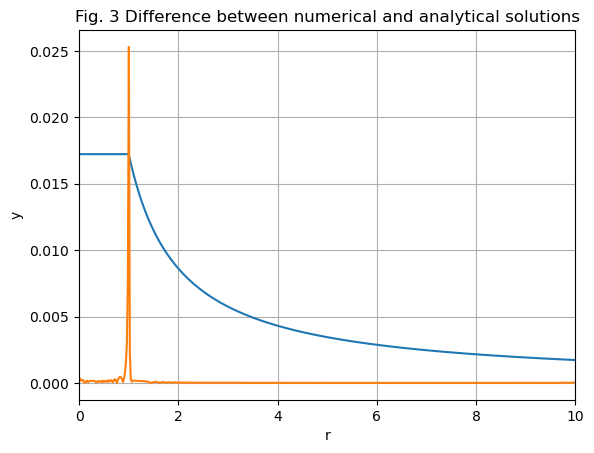

In [319]:
plt.plot(test_grid, np.abs(solution - analytic_func(test_grid)), label = r'Actual error')
plt.plot(test_grid, np.abs(resid), label = r'Residual')
plt.xlabel('r'); plt.ylabel('y')
plt.xlim(0, 10); plt.grid(True)
plt.title('Fig. 3 Difference between numerical and analytical solutions');

In [320]:
L_inf_test = np.max(np.abs(solution - analytic_func(test_grid)))
print(r'L_inf norm of the error is %g'%L_inf_test)

L_inf norm of the error is 0.0172305


As we can see, the error is the largest approximately where the function values are large, i. e. before reaching $r = 1$, where $\rho = 1$. Also the error significantly decreases for the 2nd part of the function, where $\rho = e^{-r + 1}$.